In [1]:
import os
import re

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from hnetwork import HNetwork
from visualisation import *

In [2]:
def apply_noise(pattern, noise):
    noise = (np.random.random(size=pattern.shape) > noise) * 2 - 1
    return pattern * noise

In [3]:
def subdivide_pattern(pattern, shape):
    height = pattern.shape[0] // shape[0]
    width = pattern.shape[0] // shape[1]
    subpatterns = []
    for i in range(shape[0]):
        for j in range(shape[1]):
            subpatterns.append(pattern[i*height:(i+1)*height, j*width:(j+1)*width])
    return subpatterns

def recombine_pattern(subpatterns, shape):
    height = subpatterns[0].shape[0]
    width = subpatterns[0].shape[1]
    pattern = np.zeros(shape=(shape[0] * height, shape[1] * width))
    for i in range(shape[0]):
        for j in range(shape[1]):
            pattern[i*height:(i+1)*height, j*width:(j+1)*width] = subpatterns[i * shape[1] + j]
    return pattern

In [41]:
target_shape = (300, 300)
subdivision_shape = (1, 3)
subpattern_shape = (target_shape[0] // subdivision_shape[0], target_shape[1] // subdivision_shape[1])
subpattern_count = np.product(subdivision_shape)

In [42]:
imgs = []
X = []
for path in os.listdir('./data/dogs_raw'):
    img_raw = Image.open(f"./data/dogs_raw/{path}")
    img_raw = img_raw.resize(target_shape, resample=Image.NEAREST)
    img_data = np.array(img_raw.getdata())

    pattern = np.where(img_data.mean(axis=1) > 125, 1, -1)
    subpatterns = subdivide_pattern(pattern.reshape(target_shape), shape=subdivision_shape)

    bitmap = pattern.reshape(target_shape)
    img = draw_bitmap(bitmap, scale=1)
    img.save(f"./data/dogs/{path}")
    imgs.append(img)
    X.extend(subpatterns)
X = np.array(X).reshape(len(imgs) * subpattern_count, -1)

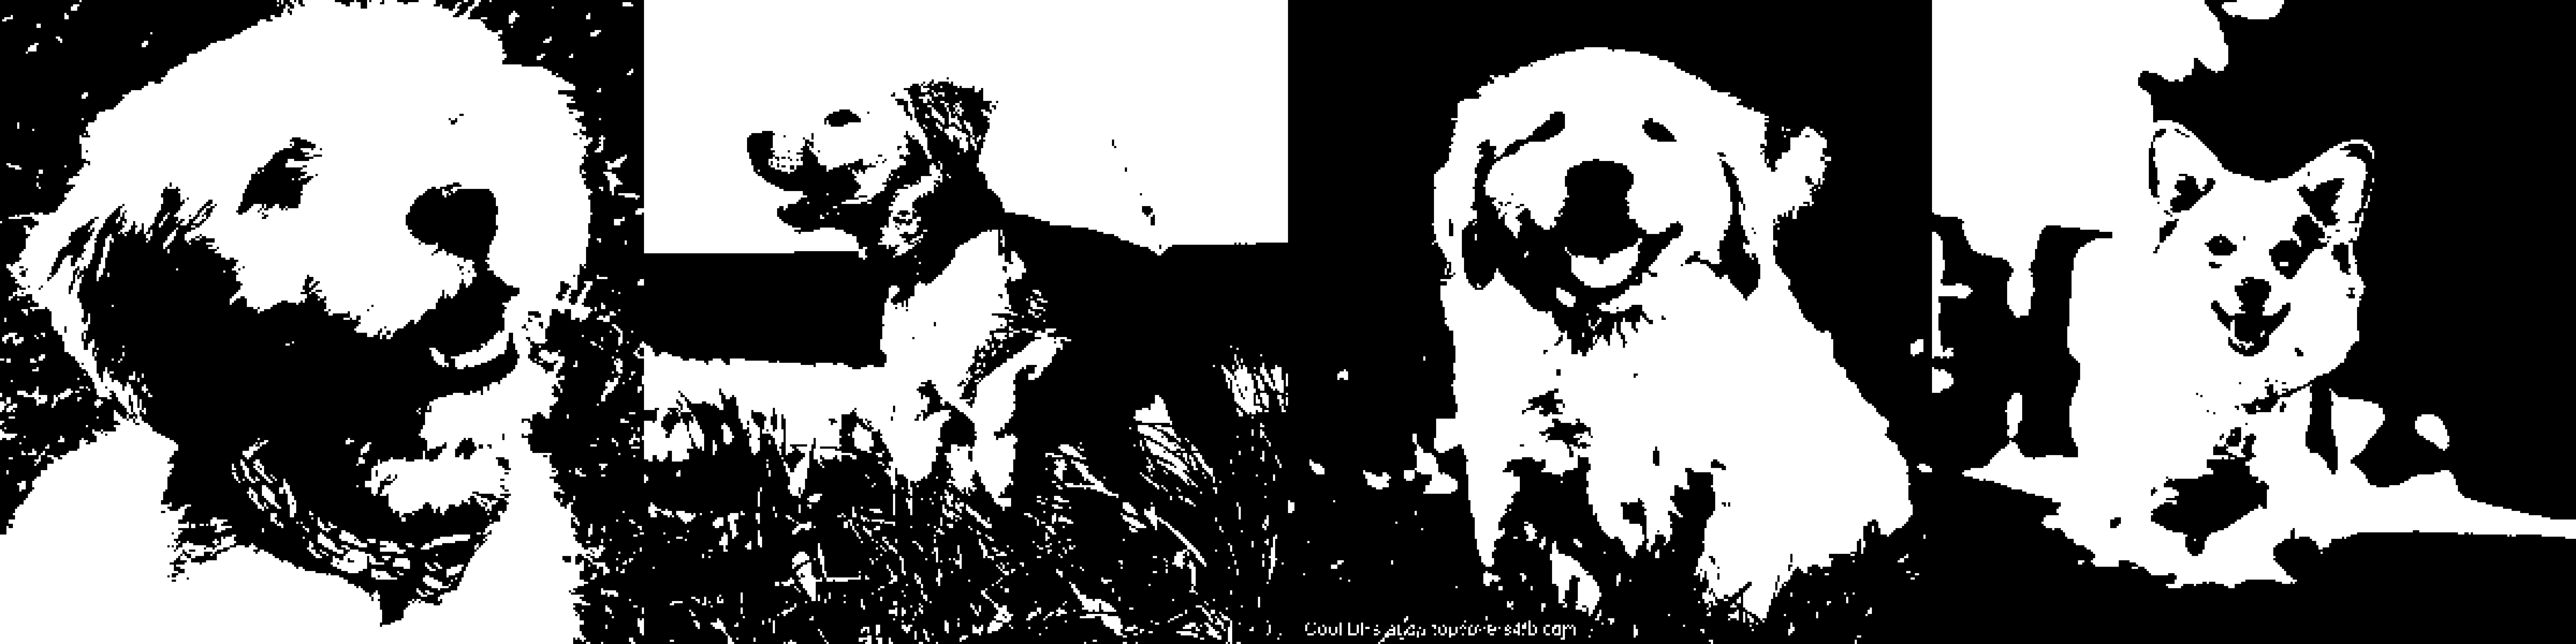

In [47]:
draw_dataset(X.reshape((12, 300, 100)))

In [48]:
hn = HNetwork(X.shape[1], train_rule='hebb', update_mode='sync')

In [49]:
hn.fit(X, epochs=100, verbose=3)

In [135]:
all_pred = []

In [148]:
img_idx = 3
X_noisy = apply_noise(X[(img_idx*subpattern_count):(img_idx*subpattern_count + subpattern_count)], 0.2)
X_noisy.shape

(3, 30000)

In [149]:
Y_pred = [hn.predict(x_noisy).reshape(subpattern_shape) for x_noisy in X_noisy]
y_pred = recombine_pattern(Y_pred, subdivision_shape)
y_pred.shape

(300, 300)

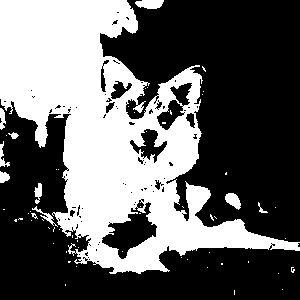

In [150]:
draw_bitmap(y_pred, scale=1)

In [151]:
all_pred.append(y_pred)

In [152]:
all_pred = np.array(all_pred)

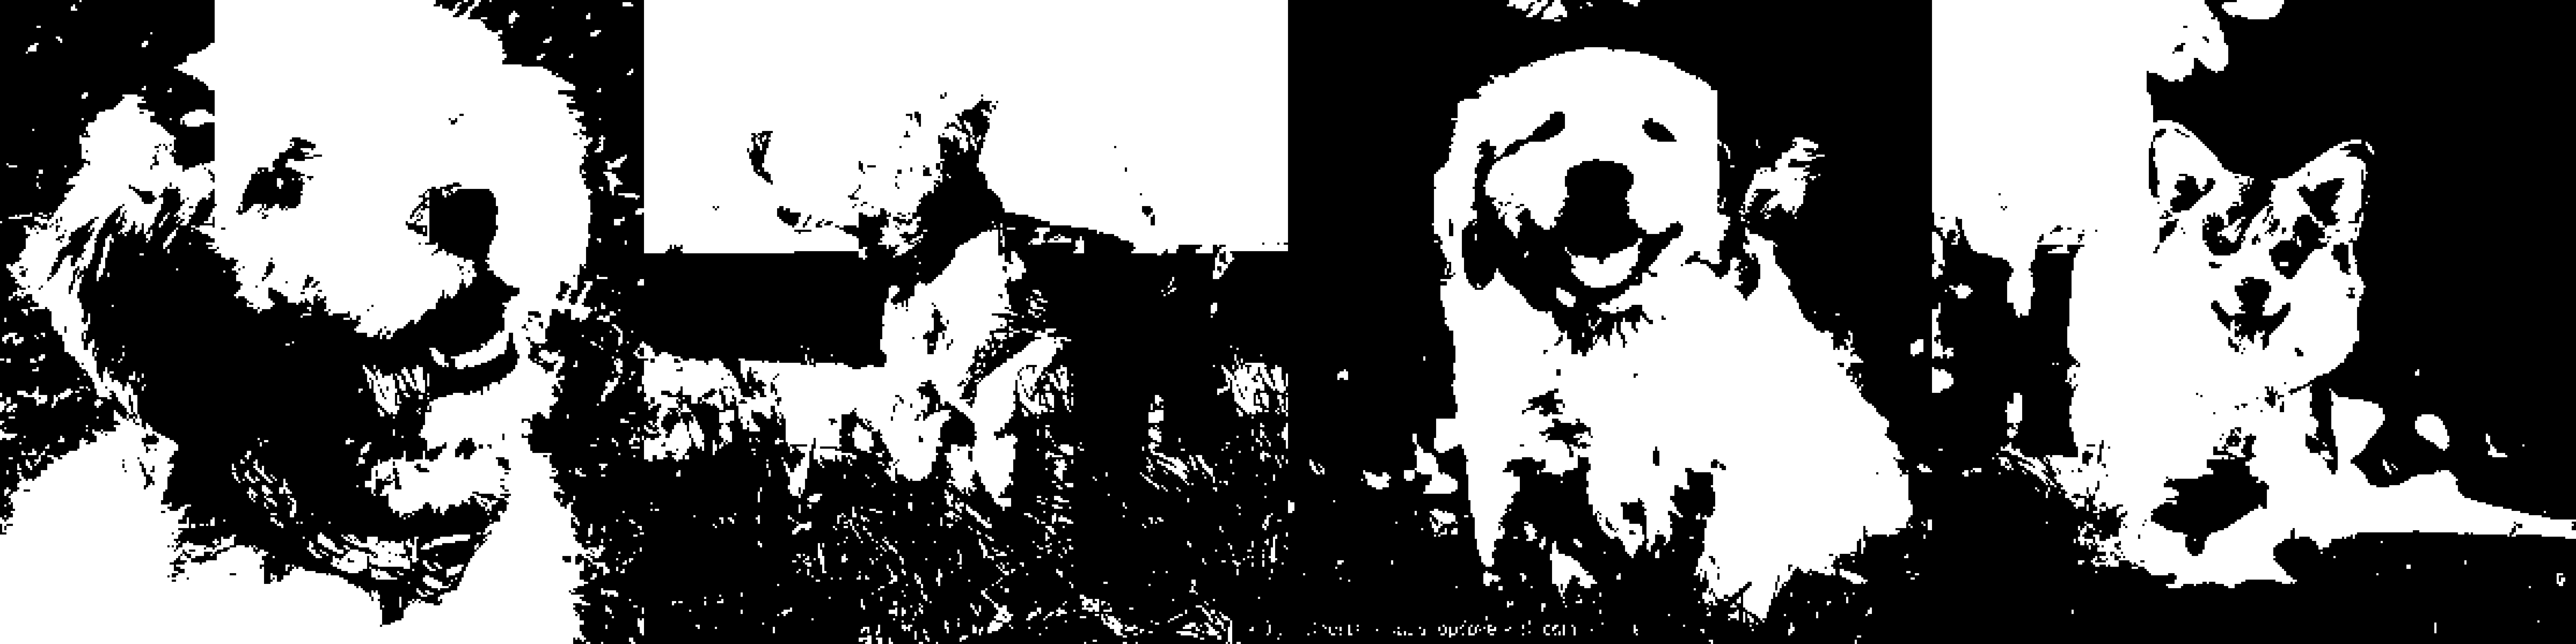

In [154]:
draw_dataset(all_pred)